<a href="https://colab.research.google.com/github/NethmiAmasha/Waste-Image-Classification-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# File and folder names
zip_file = "realwaste.zip"
dataset_folder = "realwaste_dataset"
url = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"

# Download the zip file only if it doesn't exist
if not os.path.exists(zip_file):
    !wget "{url}" -O {zip_file}

# Unzip only if the dataset folder doesn't exist
if not os.path.exists(dataset_folder):
    !unzip -q {zip_file} -d {dataset_folder}  # -q = quiet mode, no unnecessary output

print("Dataset is ready in:", dataset_folder)



--2025-10-31 20:35:35--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [  <=>               ] 656.65M  31.6MB/s    in 28s     

2025-10-31 20:36:03 (23.6 MB/s) - ‘realwaste.zip’ saved [688545323]

Dataset is ready in: realwaste_dataset


In [ ]:
import tensorflow as tf
import os

# Path to your dataset
base_path = "/content/realwaste_dataset/realwaste-main/RealWaste"

# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Training set (70%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split=0.30,   # 30% reserved for val+test
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Validation + test (30%)
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split=0.30,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Split validation+test 30% → 15% + 15%
val_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take(val_batches // 2)
test_ds = val_test_ds.skip(val_batches // 2)


print("Classes:", train_ds.class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds))
print("Val batches:", tf.data.experimental.cardinality(val_ds))
print("Test batches:", tf.data.experimental.cardinality(test_ds))

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train batches: tf.Tensor(104, shape=(), dtype=int64)
Val batches: tf.Tensor(22, shape=(), dtype=int64)
Test batches: tf.Tensor(23, shape=(), dtype=int64)


In [ ]:
#To determine the number of output neurons

num_classes = len(train_ds.class_names)
print("Number of classes:", num_classes)


Number of classes: 9


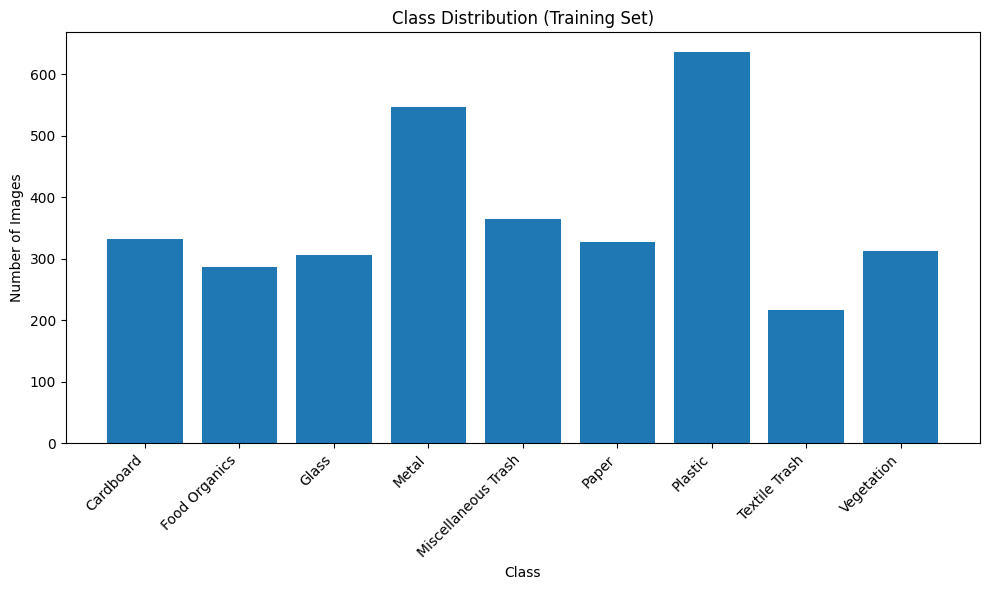

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the dataset
labels = train_ds.class_names
num_classes = len(labels)
counts = [0] * num_classes

# Iterate through the dataset to count images per class
for images, labels_batch in train_ds:
    for label in labels_batch.numpy():
        counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Prefetching and caching for performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Cache -keep data ready in memory.

Prefetch - prepare next batch while training.

AUTOTUNE - let TensorFlow choose the best prefetching speed.

In [ ]:
# Normalize pixel values
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    print("Shape of images batch:", images.shape)
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())



Shape of images batch: (32, 128, 128, 3)
Min pixel value: 0.0
Max pixel value: 1.0


Since we are just doing min max normalization doesnt matter if we divide the dataset into traning set, validation ... before or after it.

When using standard normalization techniques also we have to first divide into sets since we only have to calculate the mean, standard deviation statistics on the test set and not all. Otherwise the model is going to fit the data in an unnecessary manner.

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization



Here using sequential we make the layers all in the sequential order.

In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # slightly reduced to retain learning
    layers.Dense(num_classes, activation='softmax')
])



In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Checking the labeling technique

for images, labels in train_ds.take(1):
    print(labels.numpy())


[3 1 6 6 6 4 3 2 2 4 6 3 0 3 0 8 4 8 1 6 1 6 7 1 6 3 6 8 4 3 8 6]


Since the above code is supposed to give the labels of the first batch ( train_ds.take(1) ) we expect 32 labels. But we got less than that. That is because we have used Prefetching / caching / shuffling. Therefore it gives a random batch and not the first one. And that could contain less than 32 images if the no of images is not divisable by 32.

The above labelling method is called the sparse_categorical_crossentropy.
[100000...] this is one hot encoding.

Since sparse_categorical_crossentropy is used here we use that loss function.

Like MSE is for regression, binary_cross_entropy for 2 class problems.

In [ ]:
# configuring your model before training — how it should learn.

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 340ms/step - accuracy: 0.4712 - loss: 1.7459 - val_accuracy: 0.0938 - val_loss: 7.1731
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.7709 - loss: 0.6696 - val_accuracy: 0.0938 - val_loss: 6.9288
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.8976 - loss: 0.3410 - val_accuracy: 0.0739 - val_loss: 4.3463
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9731 - loss: 0.1303 - val_accuracy: 0.1974 - val_loss: 3.3371
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9842 - loss: 0.0680 - val_accuracy: 0.3778 - val_loss: 2.0705
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9992 - loss: 0.0242 - val_accuracy: 0.5952 - val_loss: 1.2577
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.7202 - val_loss: 0.8752
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 1.0000 - loss: 0

Plotting training and validation accuracies

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Extracting the history

# history is an object returned by model.fit() containing metrices tracked per epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


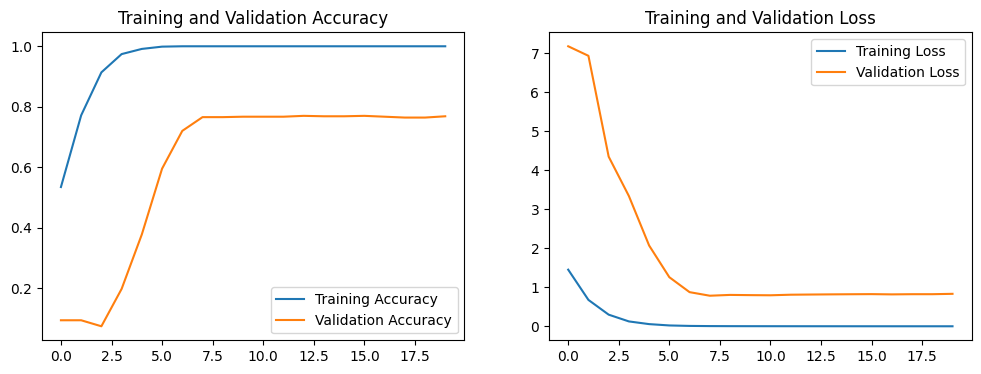

In [ ]:
epochs_range = range(20)  # x axis range

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)  # 1 row, 2 columns, first plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)  # second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()




In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.7504 - loss: 0.9057
Test Accuracy: 0.7517337203025818


### Confusion Matrix

Shows how many images of each class were correctly/misclassified

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


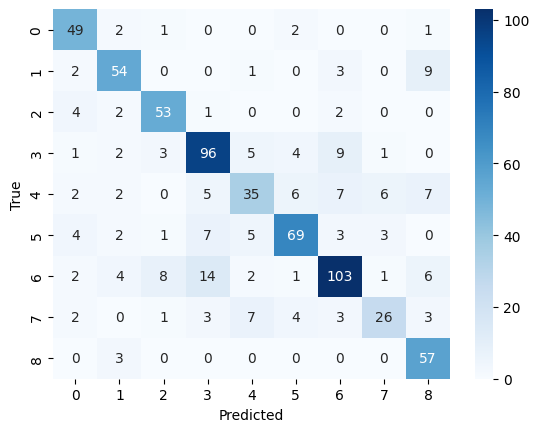

In [ ]:
# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("Adam Macro Precision:", round(precision_macro,4))
print("Adam Macro Recall:", round(recall_macro,4))
print("Adam Macro F1-score:", round(f1_macro,4))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Adam Macro Precision: 0.7418
Adam Macro Recall: 0.7519
Adam Macro F1-score: 0.741


In [ ]:
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras import layers, models


# **SGD (lr=1e-2)**

In [ ]:
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt, pandas as pd

model_sgd = models.Sequential([
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])





In [ ]:
model_sgd.compile(
    optimizer = optimizers.SGD(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
hist_sgd = model_sgd.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.4288 - loss: 1.9074 - val_accuracy: 0.0966 - val_loss: 6.2247
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.6659 - loss: 0.9825 - val_accuracy: 0.1861 - val_loss: 7.5431
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.7816 - loss: 0.6347 - val_accuracy: 0.1477 - val_loss: 4.2990
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.8807 - loss: 0.3765 - val_accuracy: 0.1761 - val_loss: 3.4143
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9370 - loss: 0.2406 - val_accuracy: 0.4545 - val_loss: 1.5926
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9872 - loss: 0.0915 - val_accuracy: 0.5810 - val_loss: 1.1902
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9962 - loss: 0.0500 - val_accuracy: 0.6619 - val_loss: 1.0060
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9999 - loss: 0

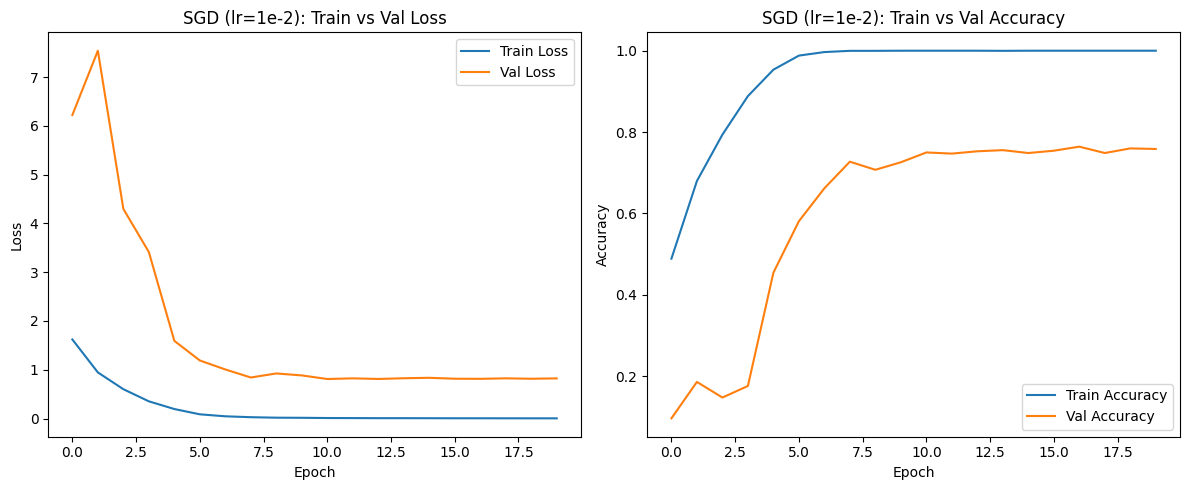

[SGD] Test Accuracy: 0.7476


In [ ]:
plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(hist_sgd.history['loss'], label='Train Loss')
plt.plot(hist_sgd.history['val_loss'], label='Val Loss')
plt.title("SGD (lr=1e-2): Train vs Val Loss")
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(hist_sgd.history['accuracy'], label='Train Accuracy')
plt.plot(hist_sgd.history['val_accuracy'], label='Val Accuracy')
plt.title("SGD (lr=1e-2): Train vs Val Accuracy")
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()


sgd_test_loss, sgd_test_acc = model_sgd.evaluate(test_ds, verbose=0)
print(f"[SGD] Test Accuracy: {sgd_test_acc:.4f}")

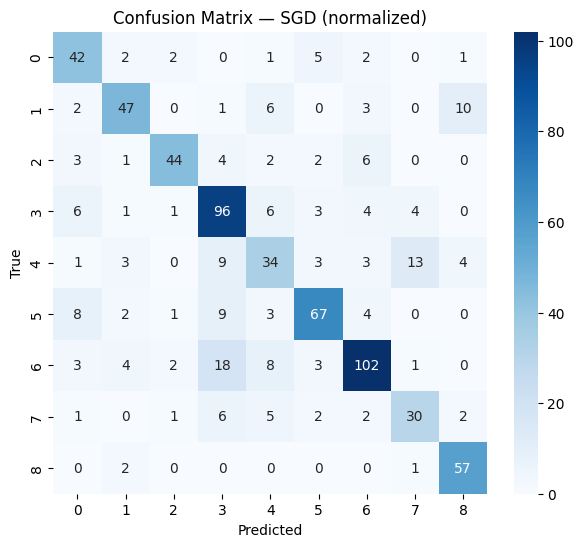

In [ ]:
y_true, y_pred = [], []
for bx, by in test_ds:
    probs = model_sgd.predict(bx, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(by.numpy())
y_true, y_pred = np.array(y_true), np.array(y_pred)

cm_sgd = confusion_matrix(y_true, y_pred, normalize='true')  # normalized by true labels

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix — SGD (normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# already have:
# y_true = np.concatenate([y for x, y in test_ds], axis=0)
# y_pred_probs = model_sgd.predict(test_ds)
# y_pred = np.argmax(y_pred_probs, axis=1)

# --- Metrics ---
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("SGD Macro Precision:", round(precision_macro,4))
print("SGD Macro Recall:", round(recall_macro,4))
print("SGD Macro F1-score:", round(f1_macro,4))


SGD Macro Precision: 0.7363
SGD Macro Recall: 0.7382
SGD Macro F1-score: 0.7329


# **SGD + Momentum**

In [ ]:
model_mom = models.Sequential([
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_mom.compile(
    optimizer = optimizers.SGD(learning_rate=5e-3, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
hist_mom = model_mom.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.4034 - loss: 2.0231 - val_accuracy: 0.0895 - val_loss: 6.3080
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5997 - loss: 1.1869 - val_accuracy: 0.3011 - val_loss: 2.3281
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.6869 - loss: 0.8845 - val_accuracy: 0.4176 - val_loss: 1.7680
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.7639 - loss: 0.6866 - val_accuracy: 0.5440 - val_loss: 1.4774
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.7987 - loss: 0.5498 - val_accuracy: 0.5625 - val_loss: 1.3837
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.8477 - loss: 0.4543 - val_accuracy: 0.6278 - val_loss: 1.1667
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.8980 - loss: 0.3122 - val_accuracy: 0.5923 - val_loss: 1.3471
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9182 - loss: 0

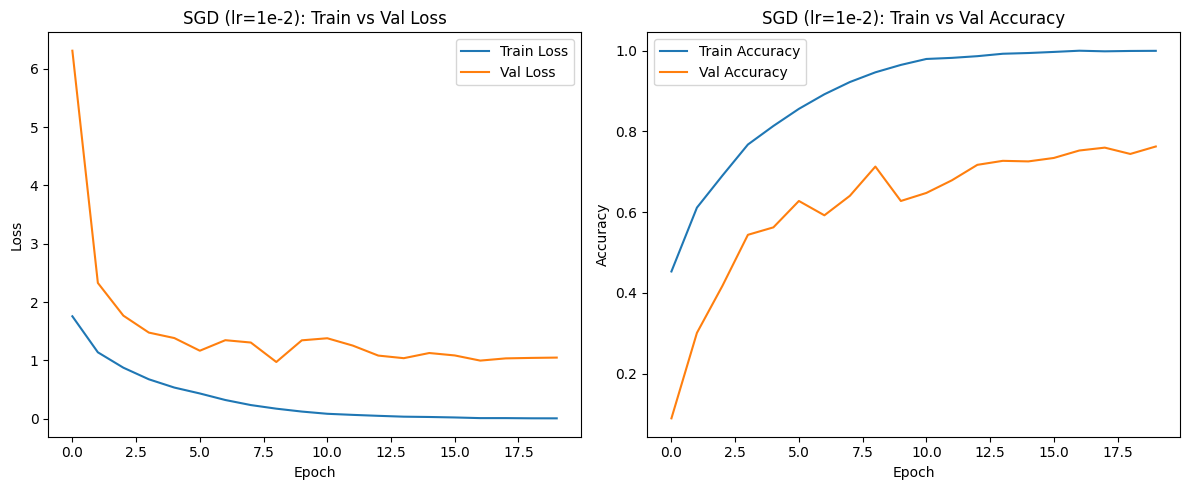

[SGD + Momentum] Test Accuracy: 0.7198


In [ ]:
plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(hist_mom.history['loss'], label='Train Loss')
plt.plot(hist_mom.history['val_loss'], label='Val Loss')
plt.title("SGD (lr=1e-2): Train vs Val Loss")
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(hist_mom.history['accuracy'], label='Train Accuracy')
plt.plot(hist_mom.history['val_accuracy'], label='Val Accuracy')
plt.title("SGD (lr=1e-2): Train vs Val Accuracy")
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()


mom_test_loss, mom_test_acc = model_mom.evaluate(test_ds, verbose=0)
print(f"[SGD + Momentum] Test Accuracy: {mom_test_acc:.4f}")

[SGD + Momentum] Test Accuracy: 0.7198
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


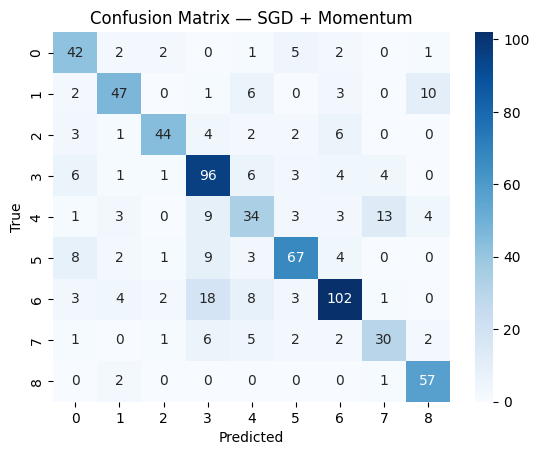

In [ ]:
mom_test_loss, mom_test_acc = model_mom.evaluate(test_ds, verbose=0)
print(f"[SGD + Momentum] Test Accuracy: {mom_test_acc:.4f}")

# --- Confusion matrix & heatmap ---
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model_mom.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix — SGD + Momentum')
plt.show()

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model_mom.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("SGD+Momentum Macro Precision:", round(precision_macro,4))
print("SGD+Momentum Macro Recall:", round(recall_macro,4))
print("SGD+Momentum Macro F1-score:", round(f1_macro,4))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
SGD+Momentum Macro Precision: 0.7147
SGD+Momentum Macro Recall: 0.7147
SGD+Momentum Macro F1-score: 0.7108


# **Optimizer Comparison Discussion**
The CNN model was trained using three optimization algorithms — Adam, SGD, and SGD + Momentum — to evaluate their impact on training stability and classification performance.
The Adam optimizer achieved the best overall performance, reaching a test accuracy of 0.7517, with macro precision = 0.7418, macro recall = 0.7519, and macro F1 = 0.7410. These results highlight Adam’s ability to adapt the learning rate for each parameter, leading to faster convergence and better generalization.

The standard SGD optimizer also performed competitively, obtaining a test accuracy of 0.7476, with macro precision = 0.7363, macro recall = 0.7382, and macro F1 = 0.7329. Although SGD converged more slowly and exhibited slightly larger oscillations in the loss curve, it ultimately reached performance levels close to Adam after several epochs.

Adding momentum (SGD + Momentum, momentum = 0.9) stabilized the gradient updates and reduced fluctuations during training but resulted in a somewhat lower test accuracy of 0.7198, with macro precision = 0.7147, macro recall = 0.7147, and macro F1 = 0.7108.

Overall, the results demonstrate that Adam provides the most efficient and stable optimization for this CNN architecture, especially on a moderate-sized image dataset. SGD remains a solid baseline with consistent results, while SGD + Momentum offers smoother training but did not surpass Adam in accuracy or F1-score within the 20-epoch training window.